In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import json
import matplotlib.pyplot as plt
import joblib
import sklearn.metrics

import torch
import torch.nn as nn


from gnn_dataset import dataset, minmax_to_json, minmax_from_json
from gnn_training import train_loop, load_model0, best_model, select_node_feats, plot_result



In [2]:

model_path = "train30/"


with open(model_path+"best_result_config.json") as f:
    config = json.load(f)
config["model_path_native"] = config["model_path"]
config["model_path"] = model_path
config

{'val_loss': 0.001037802780047059,
 'val_l1': 0.019603904336690903,
 'train_loss': 0.00023526238510385156,
 'train_l1': 0.01046442985534668,
 'epoch': 459,
 'i_re_best': '0',
 'epoch_best': 372,
 'timestamp': 1740854678,
 'checkpoint_dir_name': 'checkpoint_000000',
 'should_checkpoint': True,
 'done': True,
 'training_iteration': 1,
 'trial_id': '46254_00047',
 'date': '2025-03-01_19-44-38',
 'time_this_iter_s': 2663.949823141098,
 'time_total_s': 2663.949823141098,
 'pid': 320165,
 'hostname': 'wolfgang-cpu08',
 'node_ip': '192.168.8.28',
 'config': {'lr': 0.001,
  'batch_size': 32,
  'num_features': 1,
  'graph_layers': 12,
  'graph_hidden': 100,
  'net_layers': 3,
  'net_hidden': 48,
  'aggr': 'mean',
  'funnel_graph': False,
  'funnel_net': False,
  'graph_conv': 'SAGEConv',
  'pooling': 'addmax'},
 'time_since_restore': 2663.949823141098,
 'iterations_since_restore': 1,
 'experiment_tag': '47_aggr=mean,batch_size=32,funnel_graph=False,funnel_net=False,graph_conv=SAGEConv,graph_hid

In [3]:
def del_empty(xx):
    return [x for x in xx if x]

def build_data_path(path):
    return "/".join( del_empty(path.split("/") )[-2:])

dpath = ""

config["data_path_train"] = dpath + build_data_path(config["data_path_train"])
config["data_path_val"] = dpath + build_data_path(config["data_path_val"])
config["data_path_test"] = dpath + build_data_path(config["data_path_test"])


In [4]:
config["checkpoint_path"] = model_path+"checkpoint.pt"
config["checkpoint_path"]

'train30/checkpoint.pt'

training
Scaler Info
[1.65272519e+00 4.67046863e+02 0.00000000e+00 2.00586634e+01
 0.00000000e+00 5.76559027e+00 1.12453452e+01 1.44340962e+04
 1.07076436e+01] [9.36831281e+00 3.57281551e+03 3.84000000e+00 3.91010693e+01
 3.82026750e+01 2.45797488e+01 4.36219041e+01 2.62303944e+05
 5.47573564e+01]
[1.65272519] [9.36831281]

validation
Scaler Info
[1.65272519e+00 4.67046863e+02 0.00000000e+00 2.00586634e+01
 0.00000000e+00 5.76559027e+00 1.12453452e+01 1.44340962e+04
 1.07076436e+01] [9.36831281e+00 3.57281551e+03 3.84000000e+00 3.91010693e+01
 3.82026750e+01 2.45797488e+01 4.36219041e+01 2.62303944e+05
 5.47573564e+01]
[1.65272519] [9.36831281]

test
Scaler Info
[1.65272519e+00 4.67046863e+02 0.00000000e+00 2.00586634e+01
 0.00000000e+00 5.76559027e+00 1.12453452e+01 1.44340962e+04
 1.07076436e+01] [9.36831281e+00 3.57281551e+03 3.84000000e+00 3.91010693e+01
 3.82026750e+01 2.45797488e+01 4.36219041e+01 2.62303944e+05
 5.47573564e+01]
[1.65272519] [9.36831281]



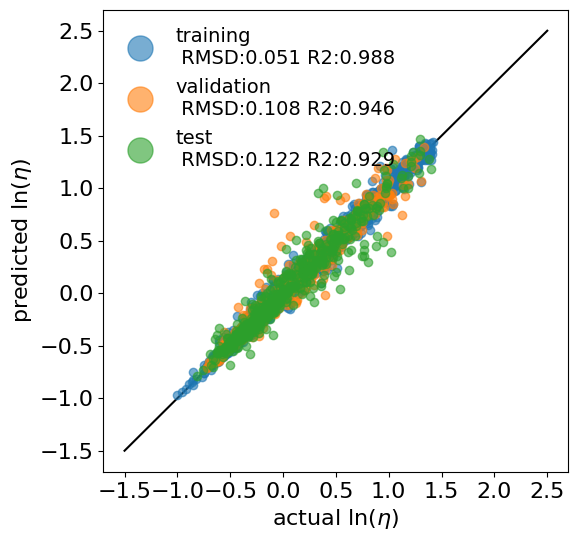

In [6]:
model, data_train = plot_result(config )

In [7]:
msize=12
mwidth = 2
fsize=16
alpha=0.7
lsize = 2    
framewidth = 3

#config["checkpoint_path_native"] = config["checkpoint_path"]
#cpath = os.path.join(config["model_path"], "checkpoint.pt")
#config["checkpoint_path"] = cpath

x_features = ["dE_nRT",'MD_density', 'MD_FV', 'MD_Rg', 'MD_SP_E', 'MD_SP_V', 'MD_SP', 'MD_HV', 'MD_RMSD']
scale_x_features_with=["log_value",'MD_density', 'MD_FV', 'MD_Rg', 'MD_SP_E', 'MD_SP_V', 'MD_SP', 'MD_HV', 'MD_RMSD']

data_train = dataset( config["data_path_train"], config["data_csv_train"], log_transform=False,
     x_features=x_features,
     y_features=["log_value"],
     keep_features=["log_a","temperature","log_viscosity","a00","identifier","iupac_name","family","graph_id"],
     scale_x_features_with=scale_x_features_with,
     keepXY=True )
data_val = dataset( config["data_path_val"], config["data_csv_val"], log_transform=False,
     x_features=x_features,
     y_features=["log_value"],
     keep_features=["log_a","temperature","log_viscosity","a00","identifier","iupac_name","family","graph_id"],
     scale_x_features_with=scale_x_features_with,
     keepXY=True )
data_test = dataset( config["data_path_test"], config["data_csv_val"], log_transform=False,
     x_features=x_features,
     y_features=["log_value"],
     keep_features=["log_a","temperature","log_viscosity","a00","identifier","iupac_name","family","graph_id"],
     scale_x_features_with=scale_x_features_with,
     keepXY=True )

model = load_model0(config)
model.eval()

losses = {"training": 0, "validation": 0, "test": 0}
l1s = {"training": 0, "validation": 0, "test": 0}
loss_fn = nn.MSELoss()
mead_fn = nn.L1Loss()

a = ["training", "validation", "test"]
b = [data_train, data_val, data_test]

fig = plt.figure(figsize=(6, 6))
for dd, data in zip(a, b):
    #for ii in range(data.n_species):
    X = data.X_scaled
    Y = data.Y_scaled
    print(dd)
    print("Scaler Info")
    print(data.scalerX.data_min_, data.scalerX.data_max_)
    print(data.scalerY.data_min_, data.scalerY.data_max_)
    print()
    
    # Y = scalerY.inverse_transform(Y)
    temperature = np.array(data.keep["temperature"])
    log_a = np.array(data.keep["log_a"])
    log_vis = np.array(data.keep["log_viscosity"])
    a00 = np.array(data.keep["a00"])
    Y = torch.unsqueeze(Y[:,0],1)
    
    # y_pred = scalerY.inverse_transform(model(X))
    batch = data.build_batch(data.graph_indexes)
    batch_x = select_node_feats(batch.x, config["num_features"])   
    y_pred = model(X, batch_x, batch.edge_index.to(torch.int64), batch.batch)
    losses[dd] += loss_fn(y_pred, Y).detach().numpy()
    l1s[dd] += mead_fn(y_pred, Y).detach().numpy()
    # resd_entropy *= m

    y_pred = data.scalerY.inverse_transform(y_pred.detach().numpy())
    y_pred = np.squeeze(y_pred)
    y_pred = y_pred + log_a - a00         


    data.keep["y_pred"] = y_pred

training
Scaler Info
[1.65272519e+00 4.67046863e+02 0.00000000e+00 2.00586634e+01
 0.00000000e+00 5.76559027e+00 1.12453452e+01 1.44340962e+04
 1.07076436e+01] [9.36831281e+00 3.57281551e+03 3.84000000e+00 3.91010693e+01
 3.82026750e+01 2.45797488e+01 4.36219041e+01 2.62303944e+05
 5.47573564e+01]
[1.65272519] [9.36831281]

validation
Scaler Info
[1.65272519e+00 4.67046863e+02 0.00000000e+00 2.00586634e+01
 0.00000000e+00 5.76559027e+00 1.12453452e+01 1.44340962e+04
 1.07076436e+01] [9.36831281e+00 3.57281551e+03 3.84000000e+00 3.91010693e+01
 3.82026750e+01 2.45797488e+01 4.36219041e+01 2.62303944e+05
 5.47573564e+01]
[1.65272519] [9.36831281]

test
Scaler Info
[1.65272519e+00 4.67046863e+02 0.00000000e+00 2.00586634e+01
 0.00000000e+00 5.76559027e+00 1.12453452e+01 1.44340962e+04
 1.07076436e+01] [9.36831281e+00 3.57281551e+03 3.84000000e+00 3.91010693e+01
 3.82026750e+01 2.45797488e+01 4.36219041e+01 2.62303944e+05
 5.47573564e+01]
[1.65272519] [9.36831281]



<Figure size 600x600 with 0 Axes>

In [8]:
data_train.keep

,Unnamed: 0,log_a,temperature,log_viscosity,a00,identifier,iupac_name,family,graph_id,y_pred
0,0,-3.521966,274.01,-6.711366,7.72,Br/C=C\Br,"1,2-acetylene dibromide",battery solvents,0,-6.673602
1,1,-3.462146,284.10,-6.840097,7.72,Br/C=C\Br,"1,2-acetylene dibromide",battery solvents,0,-6.814696
2,2,-3.410967,293.08,-6.948577,7.72,Br/C=C\Br,"1,2-acetylene dibromide",battery solvents,0,-6.903321
3,3,-3.352602,303.29,-7.059742,7.72,Br/C=C\Br,"1,2-acetylene dibromide",battery solvents,0,-7.042535
4,4,-3.302729,312.64,-7.153656,7.72,Br/C=C\Br,"1,2-acetylene dibromide",battery solvents,0,-7.128732
...,...,...,...,...,...,...,...,...,...,...
2501,2501,-4.279219,303.15,-4.301369,7.72,OCCO,"1,2-Ethanediol",battery solvents,647,-4.109686
2502,2502,-4.454525,298.15,-4.878292,7.72,OCCc1ccccc1,2-Phenyl ethanol,battery solvents,649,-4.720277
2503,2503,-4.290684,298.15,-4.465408,7.72,Oc1cccc(Cl)c1,m-Chloro phenol,battery solvents,652,-4.510702
2504,2504,-4.172266,318.15,-5.334981,7.72,Oc1cccc(Cl)c1,m-chlorophenol,battery solvents,652,-5.246419


In [9]:
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

data_csv = "ini_data/13321_2024_820_MOESM2_ESM_raw.csv"
data = pd.read_csv(data_csv)

data = data.rename(columns={"CANON_SMILES": "canonical_smiles", "Temperature (K)": "temperature",
                           "Name": "iupac_name",# "Temperature (K)": "temperature"
                           })
data["isomeric_smiles"] = data["canonical_smiles"]

data["pressure"] = 101325
data["phase"] = "Liquid"
data["MD_density"] = data["MD_density"]*1000
data["viscosity"] = data["Viscosity (cP)"]*0.001
data["log_viscosity"] = np.log(data["viscosity"])
data["MD_HV"] *= 4184.0

ff = lambda x: Descriptors.MolWt(AllChem.MolFromSmiles(x["canonical_smiles"]))/1000
data["molarweight"] = data.apply(ff, axis=1)

data["volume"] = 1 / (data["MD_density"]  / (data["molarweight"]) )
data["family"] = "battery solvents"
data["dE"] = data["MD_HV"] + data["volume"]*data["pressure"] - 8.314*data["temperature"]
data["dE_RT"] = data["dE"] / data["temperature"] / 8.314
data["dE_nRT"] = data["dE"] / data["temperature"] / 8.314 / 4 # default n=4 (chain molecule)
data["a"] = 1.090e-3*data["molarweight"]**0.5*data["temperature"]**(3/2) / (data["volume"]**(2/3)*data["dE"]  )
data["log_a"] = np.log(data["a"])
data["a00"] = 4.99+2.73
data["log_value"] = data["log_viscosity"] - data["log_a"] + data["a00"]
data["value"] = np.exp(data["log_value"])

data.keys()

Index(['Index', 'iupac_name', 'canonical_smiles', 'temperature',
       'Inverse temperature (1/K)', 'Viscosity (cP)', 'log(Viscosity)',
       'MD_density', 'MD_FV', 'MD_Rg', 'MD_SP_E', 'MD_SP_V', 'MD_SP', 'MD_HV',
       'MD_RMSD', 'Reference', 'isomeric_smiles', 'pressure', 'phase',
       'viscosity', 'log_viscosity', 'molarweight', 'volume', 'family', 'dE',
       'dE_RT', 'dE_nRT', 'a', 'log_a', 'a00', 'log_value', 'value'],
      dtype='object')

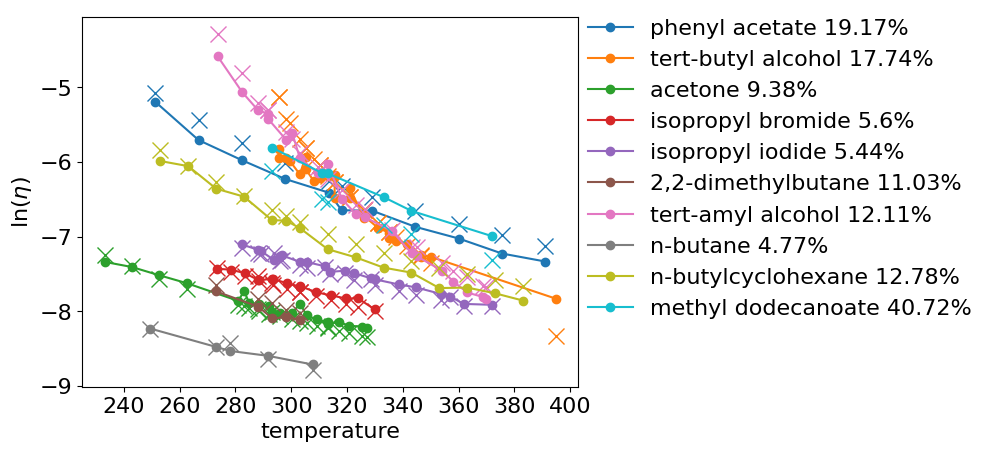

In [10]:
usmiles = np.unique(data["canonical_smiles"])

errors = 0
count = 0
plot_count=0

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
nname=""
for i,smiles in enumerate(usmiles):
    #print(smiles)

    a = ["training", "validation", "test"]
    b = [data_train, data_val, data_test]
    a = ["test"]
    b = [data_test]    
    
    for dd, ddata in zip(a, b):
        
        md = ddata.keep[ddata.keep["identifier"]==smiles]
        if md.shape[0] > 4: #and i>12:

            y = np.array(md["y_pred"])
            log_vis = np.array(md["log_viscosity"])
            vis = np.exp(md["log_viscosity"])
            T = np.array(md["temperature"])
            
            error = np.abs(( np.exp(y) - vis ) / vis)
            error = round(np.mean(error)*100,2)

            p = np.argsort(T)
            T = T[p]
            y = y[p]    
            log_vis = log_vis[p]
            #if i==0:
            #    plt.plot(T,log_vis,"kx",markersize=msize,label="experimental")
            #else:
            #    plt.plot(T,log_vis,"kx",markersize=msize)
            plt.plot(T,log_vis,"x",markersize=msize,color=colors[count])
            nname = md["iupac_name"].iloc[0]
            plt.plot(T,y,".-", label=nname+" "+str(error)+"%"#+str(md.shape[0])
                    ,markersize=msize, color=colors[count]
                    )
    
            count += 1
            #plt.legend()
            #plt.show()
            #plt.close()     
    #if count > 9 or nname == "isobutyl alcohol":
    if count>9:
        break

#plt.xlim([0,30])
#plt.ylim([0,10])

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
plt.legend(fontsize=fsize,frameon=False,bbox_to_anchor=(0.98, 1.05))
plt.xlabel(r"temperature",fontsize=fsize)  
plt.ylabel(r"ln($\eta$)",fontsize=fsize)  

plt.savefig(model_path+"/eyring_pred.png",bbox_inches='tight')
plt.savefig(model_path+"/eyring_pred.pdf",bbox_inches='tight')
plt.show()
plt.close()  

In [46]:
a = [0.122,0.127,0.13,0.17]
np.mean(a),np.std(a)

(0.13725, 0.019122957407263143)